In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv


In [2]:
from zipfile import ZipFile 
  
with ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip', 'r') as embd_zip: 
    print(embd_zip.namelist())


['GoogleNews-vectors-negative300/', 'glove.840B.300d/', 'paragram_300_sl999/', 'wiki-news-300d-1M/', 'glove.840B.300d/glove.840B.300d.txt', 'GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', 'wiki-news-300d-1M/wiki-news-300d-1M.vec', 'paragram_300_sl999/README.txt', 'paragram_300_sl999/paragram_300_sl999.txt']


**START WORKING ON DATA**

In [3]:
def DEBUG_DICTIONARY(dct, limit=10):
    for i, key in enumerate(dct.keys()):
        if i > limit: break
        print(key, dct[key])

In [4]:
from sklearn.model_selection import train_test_split

# configure train and validation data
train_data, val_data = train_test_split(pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv'), test_size=0.2, random_state=42)
sentences, targets = train_data['question_text'], train_data['target']
val_sentences, val_targets = val_data['question_text'], val_data['target']

In [5]:
train_data.head()

,qid,question_text,target
298773,3a820a95342d28ad402f,How is strategic positioning is different from...,0
815475,9fca299caa0cf8f12eac,What is the best way for promote Facebook mark...,0
1133453,de23f10ad011a6fb13c7,How much energized proton radiation does the I...,0
1076426,d2eef16340896e963a63,Would any Indian men want to marry a women tha...,0
203792,27d584db9bd46b6ab44e,Which is the best business for startups in Ind...,0


In [6]:
targets.value_counts(), val_targets.value_counts()

(0    979943
 1     64954
 Name: target, dtype: int64,
 0    245369
 1     15856
 Name: target, dtype: int64)

In [7]:
# for each word - counts how many times it occurs totally in sentences 
def configure_sentences(sentences, lower = True):
    words = {}
    for sentence in sentences:
        for word in sentence.split():
            if lower: word = word.lower()
            words[word] = words.get(word, 0) + 1
    return words

words = configure_sentences(sentences)
# look to frequencies of words in sentences
DEBUG_DICTIONARY(words)

how 230320
is 352974
strategic 203
positioning 47
different 9129
from 54432
marketing 2267
positioning? 6
what 363006
the 529651
best 49120


In [8]:
# find out what kind of words are frequently used
DEBUG_DICTIONARY({word: cnt for word, cnt in sorted(words.items(), key=lambda item: item[1], reverse=True)})

the 529651
what 363006
is 352974
a 326030
to 323761
in 298418
of 265048
i 244796
how 230320
and 204460
do 194337


In [9]:
# indexing words - in case needed
def configure_words(words):
    vocabulary = {}
    for i, word in enumerate(words.keys()):
        vocabulary[word] = i # vocabulary[i] = word
    return vocabulary

vocabulary = configure_words(words)
DEBUG_DICTIONARY(vocabulary)

how 0
is 1
strategic 2
positioning 3
different 4
from 5
marketing 6
positioning? 7
what 8
the 9
best 10


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

minimum sentence length 1 - average sentence length 13.0 - maximum sentence length 134


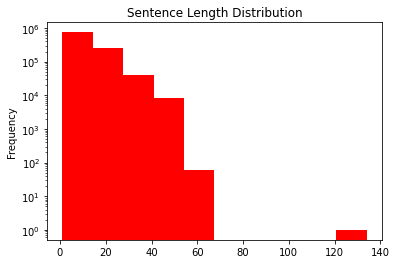

In [11]:
# returns min, avrg and max sentence length - and also displays plot(histogram) for length distribution 
def configure_sentence_statistic(sentences):
    def sentence_len(s):
        return len(s.split())
    
    sentences.apply(sentence_len).plot(title='Sentence Length Distribution',y='Length Frequency',kind='hist', colormap='autumn', logy=True);
    return np.min(sentences.apply(sentence_len)), np.round(np.mean(sentences.apply(sentence_len))), np.max(sentences.apply(sentence_len))

min, avrg, max = configure_sentence_statistic(sentences)

print('minimum sentence length {} - average sentence length {} - maximum sentence length {}'.format(min, avrg, max))

In [12]:
HIDDEN_SIZE = 30

Average length is 13, but if we take length as hiden dimension about 30-35 it should be better - as we see these lengths(30-35) are in the middle of data.
if we got 13 - most of sentences would be cut and their 70-80% would be lost...  also the cut parts should be important for the final target, but i think its no need to filter them - as start of 30 word must have enough content to predict final target - if dont, some almost same sentences should have different targets and i think this will help to learn still the right way.

In [13]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# display how the targets are distributed
def configure_target_statistic(targets):
    trg_cnt = targets.value_counts()
    labels, sizes = (np.array(trg_cnt.index)), (np.array(100*(trg_cnt/trg_cnt.sum())))
    py.iplot(go.Figure(data=[go.Pie(labels=labels, values=sizes)], layout=go.Layout(title='Target Distribution',font=dict(size=15),width=500, height=500)))
    return trg_cnt

configure_target_statistic(targets)

0    979943
1     64954
Name: target, dtype: int64

it seems that only 6.2% of targets are 1. so we need some careful model to dont go overboard - overfit ^^

In [14]:
# filters data according to given parameters
def filter_and_display_data(sentences, targets, target=0, min_len=5, max_len=30, limit=3):
    result = []
    for i, sentence in enumerate(sentences):
        sent_len = len(sentence.split(' '))
        if min_len <= sent_len and sent_len <= max_len:
            if targets[i] == target:
                result.append(sentence)
                if len(result) >= limit: break
    
    if(len(result) ==- 0):
        print('no such sequencies found.')
        return
    
    print('{} {} sentences with length between {}-{}:\n'.format(limit, 'GOOD' if target == 0 else 'BAD', min_len, max_len))
    for i, s in enumerate(result):
        print(str(i+1)+")",s)


lets see some examples of our data

In [15]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=0)

3 GOOD sentences with length between 5-30:

1) How is strategic positioning is different from marketing positioning?
2) What is the best way for promote Facebook marketing?
3) How much energized proton radiation does the ISS experience? If it is harmful levels to the astronauts, what kind of shielding does it use?


In [16]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=1)

3 BAD sentences with length between 5-30:

1) Would the left be happy if all Republicans and Conservatives were deplatformed?
2) Why are there so many self-righteous, goody two-shoes people on Quora?
3) Why do most Palestinians support terrorism?


for length <= 30 - its seems our data is normally.

In [17]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=0, min_len=120, max_len=140)

3 GOOD sentences with length between 120-140:

1) In "Star Trek 2013" why did they :

*Spoilers*
*Spoilers*
*Spoilers*
*Spoilers*

1)Make warping look quite a bit like an hyperspace jump
2)what in the world were those bright particles as soon as they jumped.
3)Why in the world did they make it possible for two entities to react in warp space in separate jumps.
4)Why did Spock get emotions for this movie.
5)What was the point of hiding the "Enterprise" underwater.
6)When they were intercepted by the dark ship, how come they reached Earth when they were far away from her.(I don't seem to remember the scene where they warp to earth).
7)How did the ship enter earth's atmosphere when it wasnt even in orbit.
8)When Scotty opened the door of the black ship , how come pike and khan didn't slow down?


In [18]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=1, min_len=120, max_len=140)

no such sequencies found.


for length 120-140 its seems our data is some kind of hard - to determine its target even by human and for target = 1 we dont have any examples - so its bad for train data to dont have all kind of basic examples, but nvm.

In [19]:
# reads and returns dictionary - key: word; value: word's embedding vector (vec. length=300)
def confnigure_embeddings(embd_path):
    word2vecs = {}
    with ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip') as embd_zip:
        for embd in embd_zip.open(embd_path, 'r'):
            word2vec = embd.decode().split(' ')
            word2vecs[word2vec[0]] = np.asarray(word2vec[1:], dtype='float32')
    return word2vecs
            
word2vecs = confnigure_embeddings('glove.840B.300d/glove.840B.300d.txt')
DEBUG_DICTIONARY(word2vecs, limit=1)

, [-0.082752   0.67204   -0.14987   -0.064983   0.056491   0.40228
  0.0027747 -0.3311    -0.30691    2.0817     0.031819   0.013643
  0.30265    0.0071297 -0.5819    -0.2774    -0.062254   1.1451
 -0.24232    0.1235    -0.12243    0.33152   -0.006162  -0.30541
 -0.13057   -0.054601   0.037083  -0.070552   0.5893    -0.30385
  0.2898    -0.14653   -0.27052    0.37161    0.32031   -0.29125
  0.0052483 -0.13212   -0.052736   0.087349  -0.26668   -0.16897
  0.015162  -0.0083746 -0.14871    0.23413   -0.20719   -0.091386
  0.40075   -0.17223    0.18145    0.37586   -0.28682    0.37289
 -0.16185    0.18008    0.3032    -0.13216    0.18352    0.095759
  0.094916   0.008289   0.11761    0.34046    0.03677   -0.29077
  0.058303  -0.027814   0.082941   0.1862    -0.031494   0.27985
 -0.074412  -0.13762   -0.21866    0.18138    0.040855  -0.113
  0.24107    0.3657    -0.27525   -0.05684    0.34872    0.011884
  0.14517   -0.71395    0.48497    0.14807    0.62287    0.20599
  0.58379   -0.13438  

In [20]:
# in each sentence replaces words with its own embedding vectors 
def configure_word2vecs(sentences, word2vecs):
    def configure_sentence(sentence, len=HIDDEN_SIZE):
        return ([word2vecs.get(word.lower(), np.zeros(300)) for word in sentence.split()] + [np.zeros(300)]*len)[:len] 
    
    return [configure_sentence(sentence) for sentence in sentences]

# embedding_sentences = configure_word2vecs(sentences, word2vecs)
# print(embedding_sentences[:10])

**START WORKING ON MODEL**

In [21]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd

In [22]:
BATCH_SIZE = 256
BATCHES = (len(sentences)+BATCH_SIZE-1)//BATCH_SIZE

EPOCHS = 2 # gpu :(
EMBD_SIZE = 300

In [23]:
gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu, torch.cuda.is_available()

(device(type='cuda'), True)

In [24]:
# long short-term memory is best suit for this case i think - as we got 1M+ train data and embedding vectors with length 300, 
# if we just convert evrything once in tensors we need more than 16gb ram and much more resources to train this data.
# also use linear layer should be good enough as there is no hard dependences - as if sentence contains 'bad' word its target is most likly 1.
# dropout layer would be good also - but as we are using only one lstm layer bc of cpu - we dont...

class LSTM(nn.Module):
    def __init__(self, input_dim=1, emb_dim=EMBD_SIZE, hid_dim=HIDDEN_SIZE, n_layers=1, output_dim=1, dropout=0.3):
        super().__init__()
        self.hid_dim, self.n_layers = hid_dim, n_layers
        
        # nn's
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hid_dim, output_dim)
        
        ### NOTE ### for dropout lstm layers has to be more than 1 - but bc of my code works only cpu i got one layer :( so it doesn't works...
#         self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, src):
        outputs, (hidden, cell) = self.lstm(src)
        return self.linear(hidden.reshape(-1, self.hid_dim))


In [25]:
# craete model - with lstm and linear layers
model = LSTM().to(gpu)

# init loss function
loss_function = nn.BCEWithLogitsLoss().to(gpu) #nn.MSELoss()

# init optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
model

LSTM(
  (lstm): LSTM(300, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

In [27]:
# evaluates and returns accuracy for predicted Y by model 
def acc_function(y_pred, y_test):
    y_pred = torch.round(torch.sigmoid(y_pred).to(gpu)).to(gpu)
    correct = (y_pred == y_test).sum().float()
    return torch.round(100*(correct/y_pred.shape[0]))

# generates and returns idx-th batch as torch tensor according to given data(sentences and targets)
def get_batch(sentences, targets, idx):
    src = configure_word2vecs(sentences[BATCH_SIZE*idx:BATCH_SIZE*(idx+1)], word2vecs)
    trg = np.asarray(targets[BATCH_SIZE*idx:BATCH_SIZE*(idx+1)], dtype='bool')
    return torch.FloatTensor(src).to(gpu), torch.FloatTensor(trg).to(gpu)

# evaluates and returns f1 score for predicted Y by model 
def f1_score(y_pred, y_test):
    tp = (y_test * y_pred).sum().to(torch.float32)
    tn = ((1 - y_test) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_test) * y_pred).sum().to(torch.float32)
    fn = (y_test * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7 # for avoid crash
    precision, recall = tp / (tp + fp + epsilon), tp / (tp + fn + epsilon)
    
    return 2*(precision*recall)/(precision + recall + epsilon)
    

**START TRAINING OF MODEL**

In [28]:
# ready for training
model.train()

VALIDATION_BATCHES = 10
# init validation data for accuracy while training - but taking only VALIDATION_BATCHES while whole data is too big.
val_sents = configure_word2vecs(val_sentences[:VALIDATION_BATCHES*BATCH_SIZE], word2vecs)
val_targs = np.asarray(val_targets[:VALIDATION_BATCHES*BATCH_SIZE], dtype='bool')

val_batch = torch.FloatTensor(val_sents).to(gpu)
val_target = torch.FloatTensor(val_targs).to(gpu)
print(type(val_batch), val_batch.shape, type(val_targets), val_targets.shape)

<class 'torch.Tensor'> torch.Size([2560, 30, 300]) <class 'pandas.core.series.Series'> (261225,)


In [29]:
BATCHES, BATCH_SIZE, get_batch(sentences, targets, 0)[0].shape, get_batch(sentences, targets, 0)[1].shape

(4082, 256, torch.Size([256, 30, 300]), torch.Size([256]))

In [30]:
# training
for e in range(EPOCHS):
    # save epoch loss and accuracy
    epoch_loss, epoch_acc = 0, 0
    for b in range(BATCHES):
        # get current batch from data
        X_batch, y_batch = get_batch(sentences, targets, b)
        
        # set the gradients to zero, before starting to do backpropragation - avoiding gradient miss direction for minimum. 
        optimizer.zero_grad()

        # predict targets for current batch and learn by comparing it to real targets with loss func.
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch.unsqueeze(1))
        
        # predict targets for validation data and eval. accuracy
        val_pred = model(val_batch)
        acc = acc_function(val_pred, val_target.unsqueeze(1))

        # gradients are "stored" by the tensors themselves - once call backward on the loss.
        loss.backward()
        
        # updates the model parameters
        optimizer.step()
        
        # add batch loss and acc to evaluate epoch loss/acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if b == 0 or (b+1) % 100 == 0:
            print(f'Epoch {(e+1)+0:03} | Batch {(b+1)+0:04}: | Loss: {epoch_loss/(b+1):.5f} | Acc: {epoch_acc/(b+1):.3f} | F1: {f1_score(val_pred, val_target.unsqueeze(1)):.3f}')
            # print(next(model.parameters()).is_cuda, X_batch.get_device(), y_batch.get_device(), y_pred.get_device(), val_pred.get_device())

    print(f'Epoch {(e+1)+0:03}: | Epoch Loss: {epoch_loss/BATCHES:.5f} | Epoch Acc: {epoch_acc/BATCHES:.3f}')

Epoch 001 | Batch 0001: | Loss: 0.65673 | Acc: 94.000 | F1: 0.619
Epoch 001 | Batch 0100: | Loss: 0.36776 | Acc: 94.000 | F1: 0.130
Epoch 001 | Batch 0200: | Loss: 0.29554 | Acc: 94.000 | F1: 0.108
Epoch 001 | Batch 0300: | Loss: 0.25834 | Acc: 93.980 | F1: 0.044
Epoch 001 | Batch 0400: | Loss: 0.23097 | Acc: 93.985 | F1: 0.035
Epoch 001 | Batch 0500: | Loss: 0.21250 | Acc: 93.994 | F1: 0.032
Epoch 001 | Batch 0600: | Loss: 0.20035 | Acc: 94.010 | F1: 0.028
Epoch 001 | Batch 0700: | Loss: 0.19125 | Acc: 94.041 | F1: 0.031
Epoch 001 | Batch 0800: | Loss: 0.18470 | Acc: 94.058 | F1: 0.021
Epoch 001 | Batch 0900: | Loss: 0.17898 | Acc: 94.051 | F1: 0.025
Epoch 001 | Batch 1000: | Loss: 0.17399 | Acc: 94.083 | F1: 0.032
Epoch 001 | Batch 1100: | Loss: 0.17013 | Acc: 94.115 | F1: 0.033
Epoch 001 | Batch 1200: | Loss: 0.16690 | Acc: 94.147 | F1: 0.026
Epoch 001 | Batch 1300: | Loss: 0.16423 | Acc: 94.186 | F1: 0.026
Epoch 001 | Batch 1400: | Loss: 0.16151 | Acc: 94.209 | F1: 0.026
Epoch 001 

**START WORKING ON TEST DATA**

In [31]:
# init test data
test_data = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')
sentences, targets = test_data['question_text'], []
TEST_BATCHES = (len(sentences)+BATCH_SIZE-1)//BATCH_SIZE

In [32]:
test_data.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


minimum sentence length 1 - average sentence length 13.0 - maximum sentence length 87


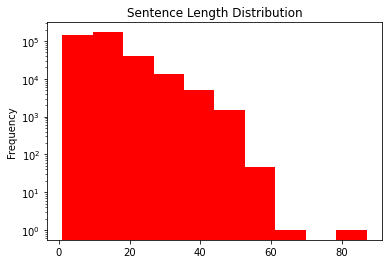

In [33]:
min, avrg, max = configure_sentence_statistic(sentences)

print('minimum sentence length {} - average sentence length {} - maximum sentence length {}'.format(min, avrg, max))

In [34]:
len(sentences), len(targets), TEST_BATCHES

(375806, 0, 1468)

**PREDICT TEST DATA ACCORDING TO OUR MODEL**

In [35]:
model.eval()
with torch.no_grad():
    for b in range(TEST_BATCHES):
        # get current batch
        X_batch = torch.FloatTensor(configure_word2vecs(sentences[BATCH_SIZE*b:BATCH_SIZE*(b+1)], word2vecs)).to(gpu)
        
        # predict batch according to our trained model
        trg = torch.round(torch.sigmoid(model(X_batch))).cpu().numpy().squeeze()
        targets.extend(trg)
        
        if b == 0 or (b+1) % 100 == 0: print(f'Batch {(b+1)+0:04} predicted')

Batch 0001 predicted
Batch 0100 predicted
Batch 0200 predicted
Batch 0300 predicted
Batch 0400 predicted
Batch 0500 predicted
Batch 0600 predicted
Batch 0700 predicted
Batch 0800 predicted
Batch 0900 predicted
Batch 1000 predicted
Batch 1100 predicted
Batch 1200 predicted
Batch 1300 predicted
Batch 1400 predicted


In [36]:
# save data to submit
test_targets = (np.array(targets) >= 0.5).astype(np.int)

submit = pd.DataFrame({"qid": test_data['qid'], "prediction": test_targets})
submit.to_csv("submission.csv", index=False)

In [37]:
# display results
submit.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


As it seems % of our prediction is almost like train data. that seems good ^^ 

lets see some examples of our prediction

In [38]:
configure_target_statistic(submit['prediction'])

0    360397
1     15409
Name: prediction, dtype: int64

In [39]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=0)

3 GOOD sentences with length between 5-30:

1) When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?
2) What is it really like to be a nurse practitioner?
3) Is education really making good people nowadays?


In [40]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=1)

3 BAD sentences with length between 5-30:

1) Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?
2) Why do so many people on this damn site not actually answer the question, but give some stupid and probably fake anecdotes instead?
3) Why most Telugu and Marathi Muslims speak Urdu and are ashamed of their native languages?


in one look - it seems our model is working well.

In [41]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=1, min_len=100, max_len=150)

no such sequencies found.


In [42]:
filter_and_display_data(sentences, np.asarray(targets, dtype='int'), target=1, min_len=100, max_len=150)

no such sequencies found.


if there are no long sequencies in test set - it's just fine.